## Analyzing outputs of 100 parameter sets ensemble simulaitons
Analyzing updated batch of ensemble simulations since 'sim_opt100.ipynb'. <br/>
Simulation outputs stored: /home/disk/eos8/ach315/upscale/sims/opt (previous outputs now moved to archive)

In [399]:
import os
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import xarray as xr
import datetime
import seaborn as sns

# my functions
from funcs import fold
#from funcs import get_filelist # *** why this is not working?

### 1. Loading in parameter info

In [2]:
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params.head()

juv_leaves  stayGreen  rmax_ltir  phyllo  LM_min  Vcmax   Vpmax    g1  \
0          23       4.44       1.24    3.31   98.77  77.29   92.57  9.86   
1          16       7.13       0.55    3.98   89.85  67.10   87.81  1.37   
2          21       6.51       1.00    3.04   81.24  66.65   81.56  3.88   
3          24       4.67       0.68    3.24   97.70  69.56   69.67  4.86   
4          20       4.32       0.82    3.13  115.08  64.44  101.27  6.31   

   ref_potential  rmax_ltar  
0          -3.38       0.62  
1          -2.83       0.28  
2          -2.63       0.50  
3          -3.63       0.34  
4          -3.40       0.41

### 2. Reading in simulation outputs

In [3]:
def get_filelist(path):
    '''
    For the given path, get the List of all files in the directory tree
    including those in subdirectories
    '''
    # create a list of file and sub directories names in the given directory 
    filelist = os.scandir(path)
    allfiles = list()
    # iterate over all the entries
    for entry in filelist:
        # create full path
        fullpath = os.path.join(path, entry)
        # if entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullpath):
            allfiles = allfiles + get_filelist(fullpath)
        else:
            allfiles.append(fullpath)
    return allfiles

In [457]:
%%time

# fetching all simulation outputs
#filelist = get_filelist('/home/disk/eos8/ach315/upscale/sims/opt/')
filelist = get_filelist('/home/disk/eos8/ach315/upscale/sims/opt/1961')

# manual update of maizsim output column name
cols = ['year', 'cvar', 'site',
        'date', 'jday', 'time', 
        'leaves', 'mature_lvs', 'drop_lvs', 'LA', 'LA_dead', 'LAI', 
        'RH', 'leaf_WP', 'PFD', 'solrad', 'temp_soil', 'temp_air', 'temp_can', 'ET_dmd', 'ET_suply',
        'Pn', 'Pg', 'resp', 'av_gs', 'LAI_sunlit', 'LAI_shaded', 'PFD_sunlit', 'PFD_shaded', 
        'An_sunlit', 'An_shaded', 'Ag_sunlit', 'Ag_shaded', 'gs_sunlit', 'gs_shaded', 'VPD',
        'N', 'N_dmd', 'N_upt', 'N_leaf', 'PCRL', 'dm_total', 'dm_shoot', 'dm_ear', 'dm_totleaf', 'dm_dropleaf', 
        'df_stem', 'df_root', 'roil_rt', 'mx_rootdept', 'available_water', 'soluble_c', 'note']

CPU times: user 109 ms, sys: 124 ms, total: 233 ms
Wall time: 299 ms


In [458]:
%%time

years = []
cvars = []
sites = []
data_all = []
issues = []

files = filelist[:]

for file in files:
    # extrating basic file info
    year = file.split('/')[-3]
    site = file.split('/')[-1].split('_')[1]
    cvar = file.split('/')[-1].split('_')[-1].split('.')[0]
    
    # reading in file and setting up structure
    with open(file, 'r') as f:
        f.seek(0, os.SEEK_END) # moving the pointer to the very end of the file
                               # * f.seek(offset, whence)
                               # * The position is computed from adding offset to a reference point,
                               # * the reference point is selected by the whence argument.
                               # * os.SEEK_SET (=0)
                               # * os.SEEK_CUR (=1)
                               # * os.SEEK_END (=2)
        f.seek(f.tell() - 3000, os.SEEK_SET) # finding the current position (which should be at the very end of the file)
                                             # and counting back a few positions 
                                             # and reading forward from there
                                             # * f.tell() returns an integer giving the file object’s 
                                             # * current position in the file represented as number of bytes 
                                             # * from the beginning of the file when in binary mode 
                                             # * and an opaque number when in text mode.

        for line in f:
            f_content = f.readlines()

        if len(f_content[-1]) == 523: # character length of a normal output
            sim_output = list(f_content[-1].split(','))
            data = [i.strip() for i in sim_output]
            data.insert(0, year)
            data.insert(1, cvar)
            data.insert(2, site)
            data_all.append(data)

        else: 
            issues.append(file)

# converting output to dataframe
df_sims = pd.DataFrame(data_all, columns=cols)
df_sims.dm_total = df_sims.dm_total.astype(float)
df_sims.dm_ear = df_sims.dm_ear.astype(float)
df_issues = pd.Series(issues, dtype='str')

# storing outputs
# df_issues.to_csv('/home/disk/eos8/ach315/upscale/test/sims_issues.txt')
# df_sims.to_csv('/home/disk/eos8/ach315/upscale/test/sims_6190_all.txt')

CPU times: user 2.02 s, sys: 955 ms, total: 2.98 s
Wall time: 1min 16s


### Setting up site info

In [405]:
# read in station & site-year info
df_site_nyears = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_nyears_crithr2.csv', index_col=0)
df_stations_9110 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/stations_info_9110.csv', usecols=[0,1,3,4,8,9,10])
df_sites_info = df_stations_9110[df_stations_9110.USAF.isin(df_site_nyears.site)]
df_sites_info.columns = ['site', 'class', 'station', 'state', 'tzone', 'lat', 'lon']

# merge site info & site-years info
df_sites_info = pd.merge(df_sites_info, df_site_nyears, on='site')

# drop stations from Alaska, Guam, Hawaii & Puerto Rico
df_sites_info = df_sites_info[(df_sites_info.state != 'AK') & (df_sites_info.state != 'GU') & 
                              (df_sites_info.state != 'HI')& (df_sites_info.state != 'PR')]

# final station list
df_sites_info.reset_index(inplace=True, drop=True)
df_sites_info.site = df_sites_info.site.astype('str')
df_sites_info.head()

site  class                    station state  tzone     lat     lon  \
0  722010      1         KEY WEST INTL ARPT    FL     -5  24.550 -81.750   
1  722020      1              MIAMI INTL AP    FL     -5  25.817 -80.300   
2  722030      1  WEST PALM BEACH INTL ARPT    FL     -5  26.683 -80.100   
3  722050      1          ORLANDO INTL ARPT    FL     -5  28.433 -81.333   
4  722056      1      DAYTONA BEACH INTL AP    FL     -5  29.183 -81.067   

   years  
0     25  
1     29  
2     19  
3     19  
4     19

### Gropuing simulation outputs by cultivars or sites

In [467]:
df_sims.cvar = df_sims.cvar.astype(float)
df_sims_sitemean = df_sims.groupby(['site']).mean()
df_sims_cvarmean = df_sims.groupby(['cvar']).mean()

### Visualization

Text(0, 0.5, 'ear biomass (g/plant)')

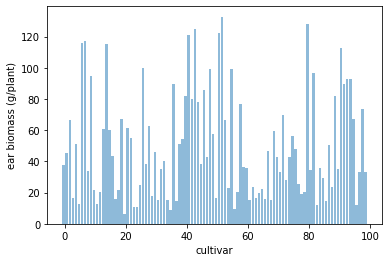

In [407]:
width=0.8
x = np.arange(len(df_sims_cvarmean.dm_ear))
plt.bar(x-width/2, df_sims_cvarmean.dm_ear, width, alpha=0.5)
plt.xlabel('cultivar')
plt.ylabel('ear biomass (g/plant)')

Text(0, 0.5, 'ear biomass (g/plant)')

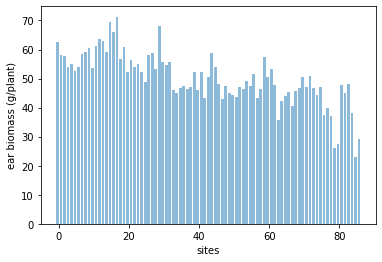

In [408]:
width=0.8
x = np.arange(len(df_sims_sitemean.dm_ear))
plt.bar(x-width/2, df_sims_sitemean.dm_ear, width, alpha=0.5)
plt.xlabel('sites')
plt.ylabel('ear biomass (g/plant)')

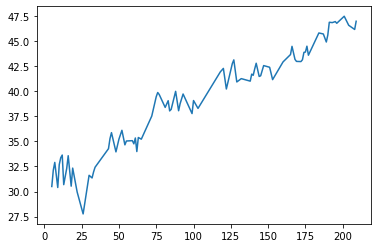

In [508]:
plt.plot(sites.lat)

### Average yield outcome from all cultivars

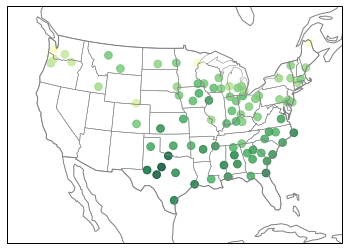

In [409]:
from palettable.colorbrewer.sequential import YlGn_9
sites = df_sites_info[df_sites_info.site.isin(df_sims_sitemean.index)]

fig = plt.figure(figsize=(6,5))
ax1 = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])
ax1.scatter(sites.lon, sites.lat, transform=ccrs.PlateCarree(), 
            s=60, c=df_sims_sitemean.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.8)
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)

Apparently there are still sites that are having trouble reaching later developmental stages <br/>
-- mostly in Northern locations

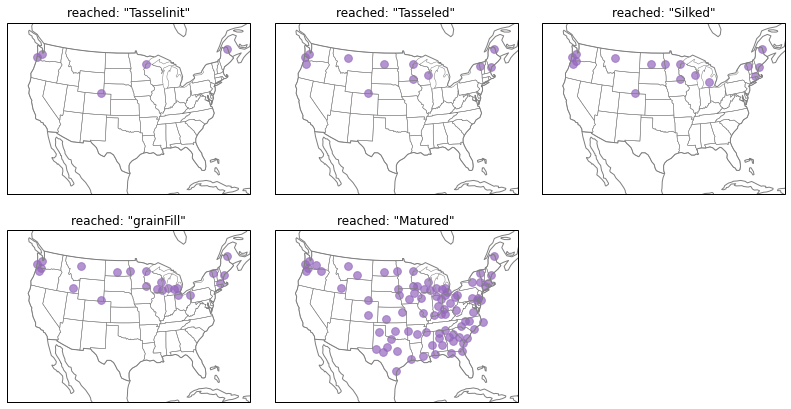

In [501]:
fig = plt.figure(figsize=(12,7))
stages = ['"Tasselinit"', '"Tasseled"', '"Silked"', '"grainFill"', '"Matured"']

for i in np.arange(1,6):
    ax = fig.add_subplot(2,3,i, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    test_sites = set(df_sims[df_sims.note == stages[i-1]].site)
    test_sites_loc = df_sites_info[df_sites_info.site.isin(test_sites)]
    ax.scatter(test_sites_loc.lon, test_sites_loc.lat, transform=ccrs.PlateCarree(), 
                s=60, c='tab:purple', alpha=0.7)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title('reached: ' + stages[i-1])
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.1, hspace=-0.3)

### Full visualization of sim outputs from year 1961

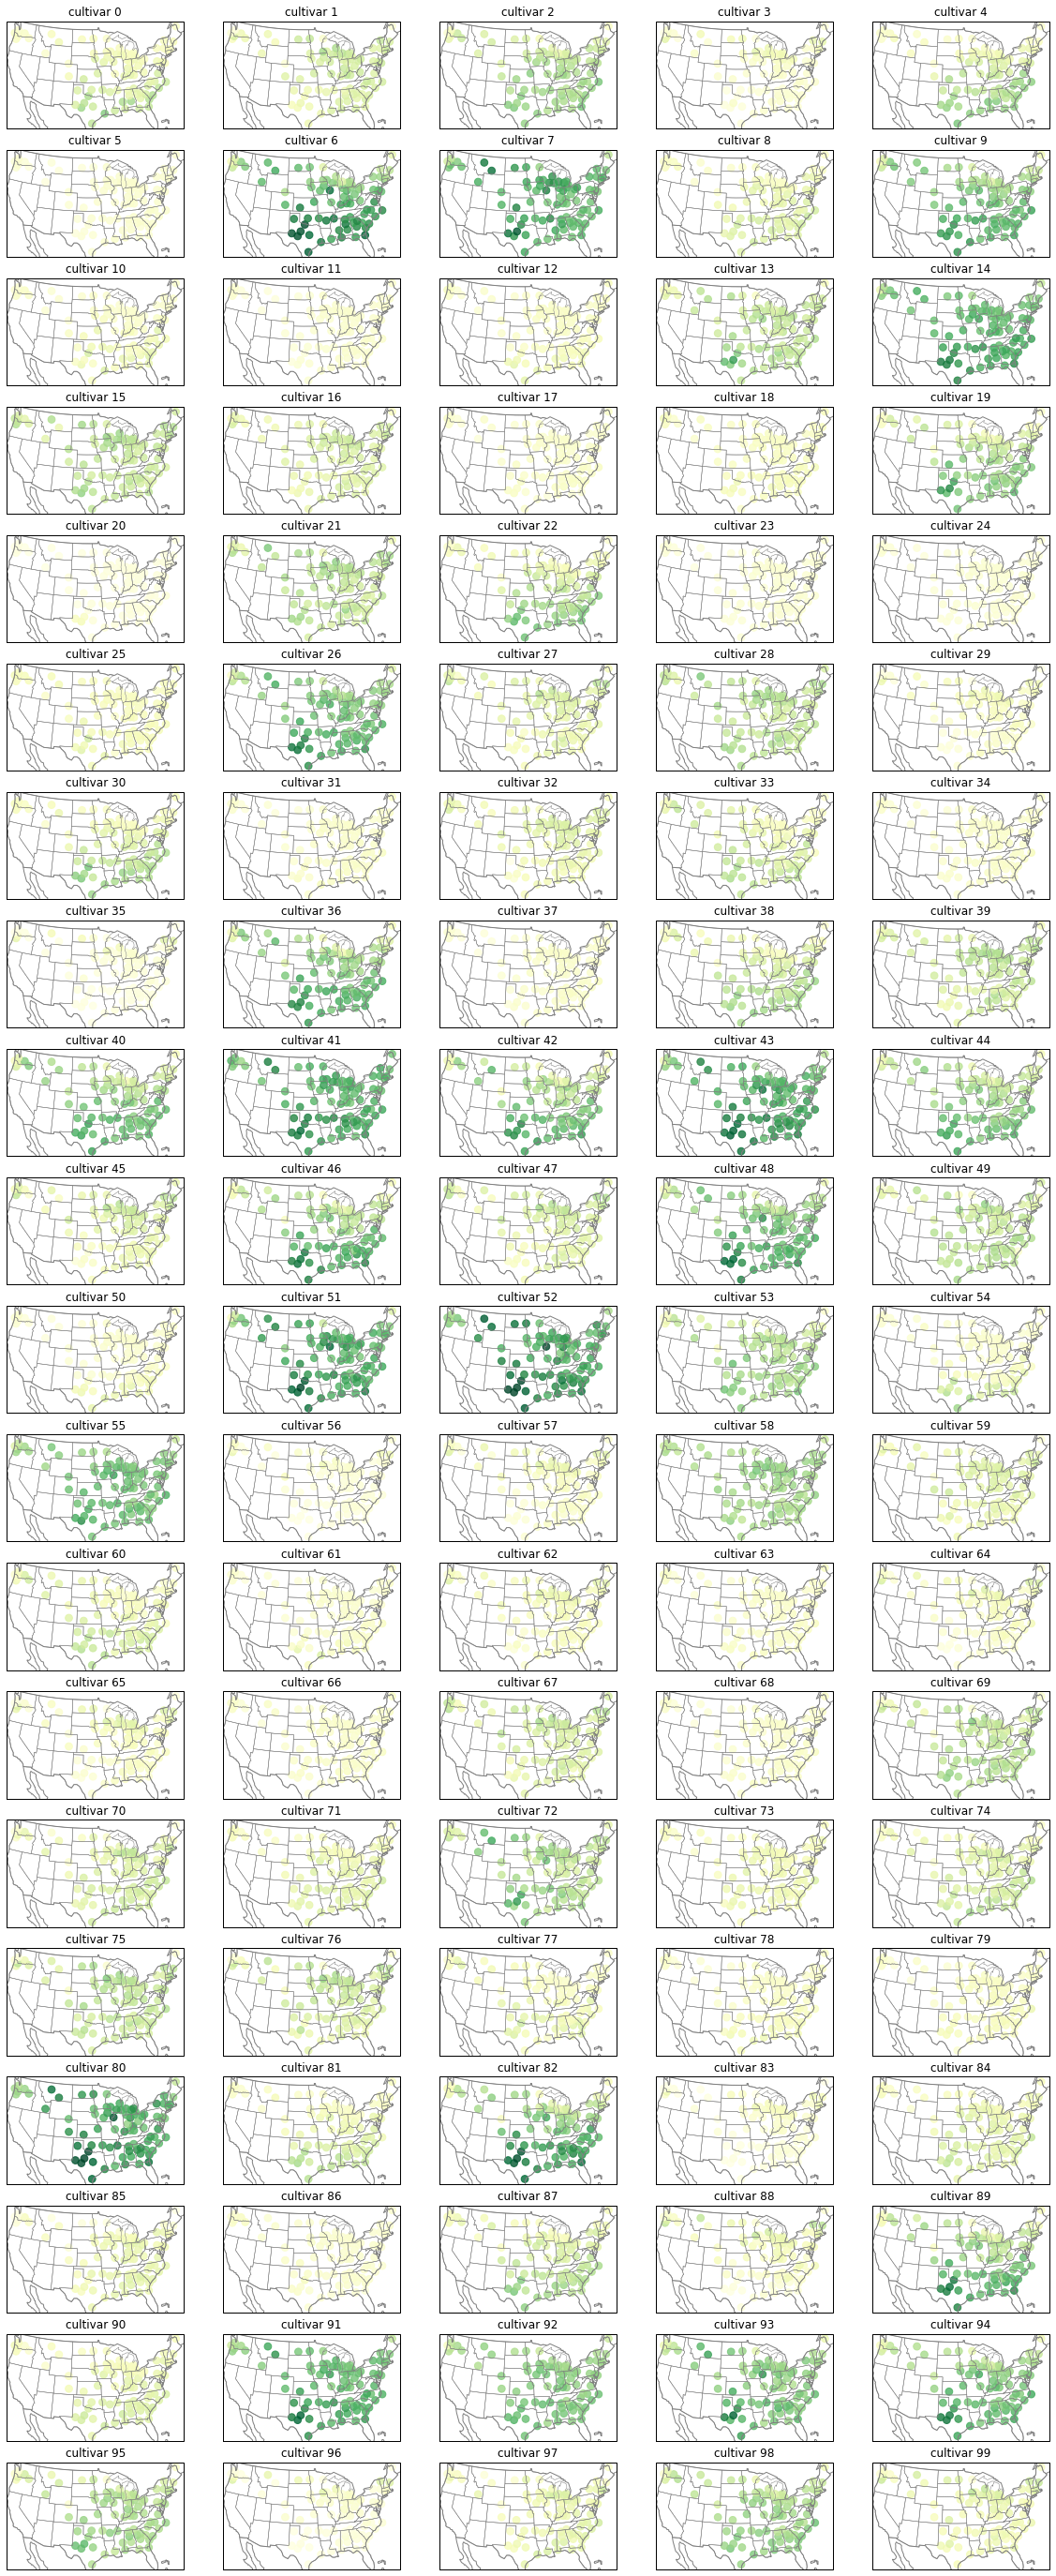

In [542]:
from palettable.colorbrewer.sequential import YlGn_9

cvars = np.arange(0,100)
extent = [-123, -72, 19, 53]

sites = df_sites_info[df_sites_info.site.isin(df_sims_sitemean.index)]

fig, axs = plt.subplots(20, 5, figsize=(20,50), 
                        subplot_kw={'projection': ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35)})

for ax, cvar in zip(axs.flatten(), cvars):
    df_sub = df_sims[df_sims.cvar == cvar]
    ax.scatter(sites.lon, sites.lat, transform=ccrs.PlateCarree(), 
               s=60, c=df_sub.dm_ear, cmap=YlGn_9.mpl_colormap, vmin=0, vmax=200, alpha=0.8)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set(title='cultivar ' + str(cvar))

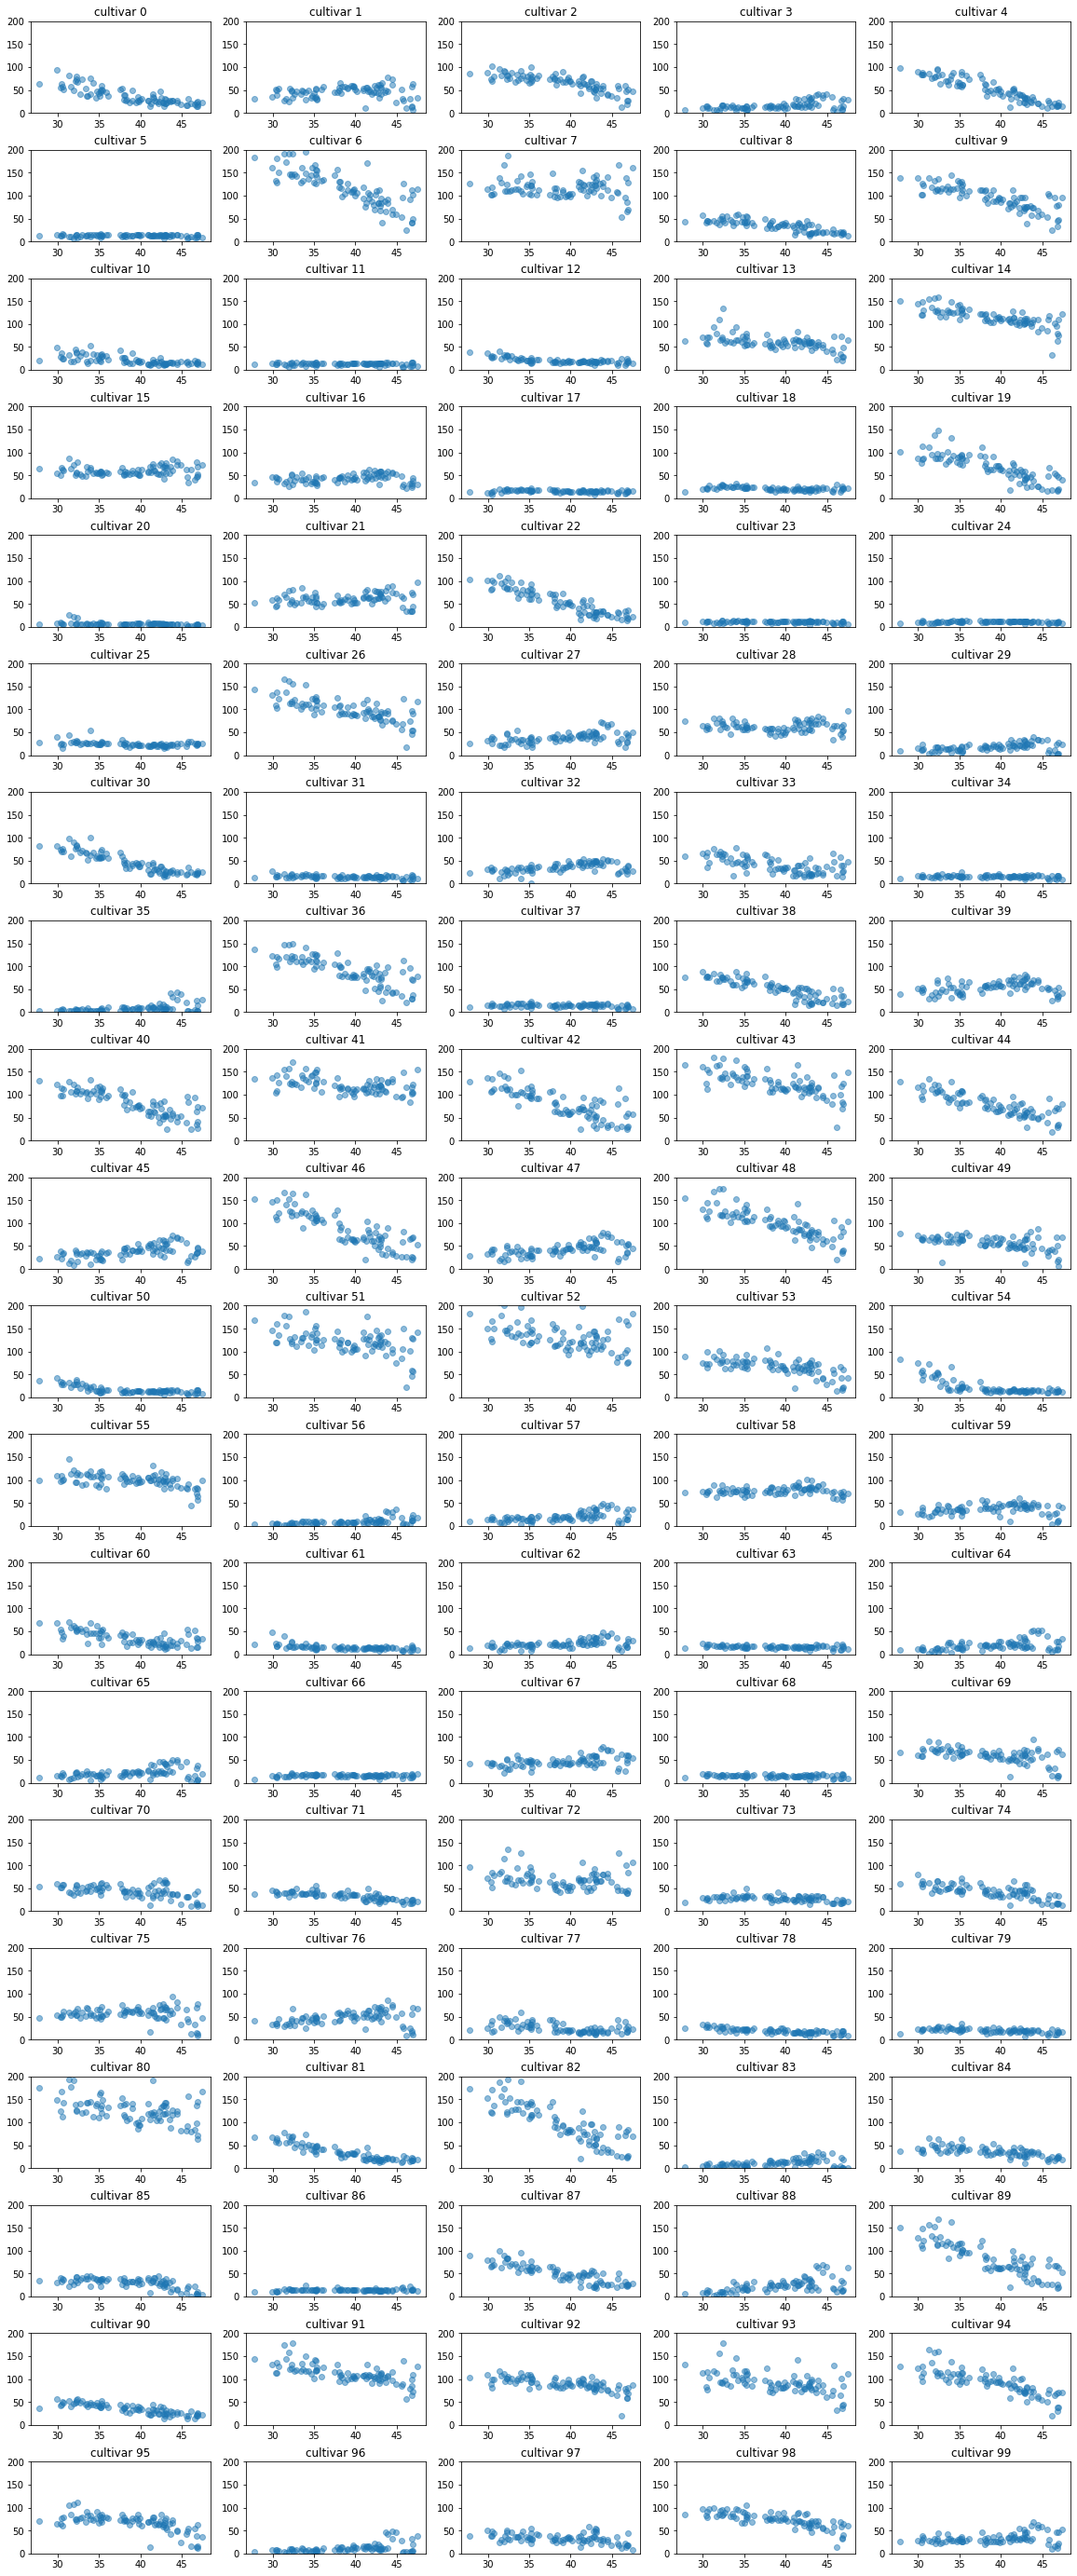

In [543]:
cvars = np.arange(0,100)

fig, axs = plt.subplots(20, 5, figsize=(20,50))
for ax, cvar in zip(axs.flatten(), cvars):
    df_sub = df_sims[df_sims.cvar == cvar]
    ax.scatter(sites.lat, df_sub.dm_ear, alpha=0.5)
    ax.set_ylim(0,200)
    ax.set(title='cultivar ' + str(cvar))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

### Merging datasets

In [587]:
df_sims_m = pd.merge(df_sims, df_params, on='cvar')
df_sims_merged = pd.merge(df_sims_m, sites, on='site')
df_sims_merged.head()

year  cvar    site        date   jday time leaves mature_lvs drop_lvs  \
0  1961   0.0  722060  07/19/1961  22481    2  23.00         23       18   
1  1961   1.0  722060  08/15/1961  22508   13  18.00         18       15   
2  1961   2.0  722060  07/31/1961  22493   15  21.00         21       18   
3  1961   3.0  722060  08/03/1961  22496    6  25.00         25       20   
4  1961   4.0  722060  07/31/1961  22493    8  21.00         21       17   

       LA  ...    g1 ref_potential rmax_ltar class                 station  \
0  302.09  ...  9.86         -3.38      0.62     1  JACKSONVILLE INTL ARPT   
1  160.24  ...  1.37         -2.83      0.28     1  JACKSONVILLE INTL ARPT   
2  188.85  ...  3.88         -2.63      0.50     1  JACKSONVILLE INTL ARPT   
3  354.63  ...  4.86         -3.63      0.34     1  JACKSONVILLE INTL ARPT   
4  329.70  ...  6.31         -3.40      0.41     1  JACKSONVILLE INTL ARPT   

  state tzone   lat   lon years  
0    FL    -5  30.5 -81.7    27  
1    FL    -5  30.5 -81.7    27  
2    FL    -5  30.5 -81.7    27  
3    FL    -5  30.5 -81.7    27  
4    FL    -5  30.5 -81.7    27  

[5 rows x 70 columns]

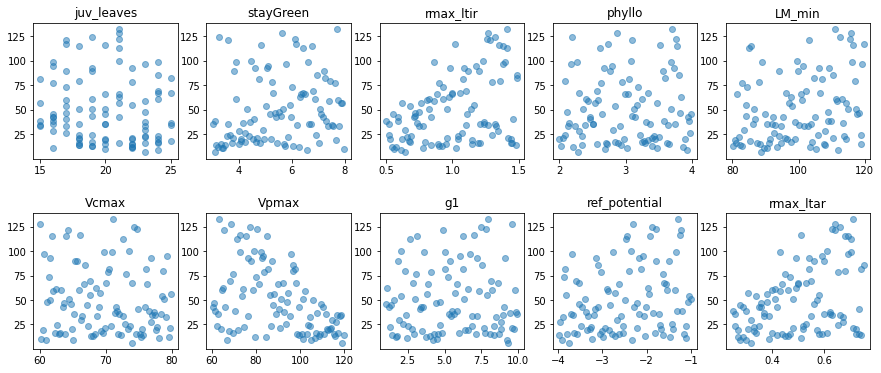

In [504]:
# *** should try to further segregate this graph by location (North vs. South)

fig = plt.figure(figsize=(15,6))

for i in np.arange(1,11): 
    ax = fig.add_subplot(2,5,i)
    ax.scatter(df_params.iloc[:,i-1], df_sims_cvarmean.dm_ear, alpha=0.5)
    ax.set(title=df_params.columns[i-1])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)


### Seperating North vs. South

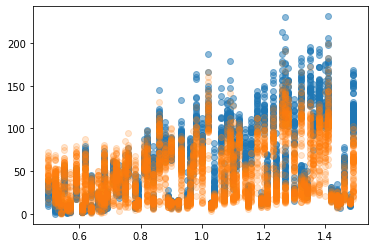

In [610]:
df_sims_south = df_sims_merged[df_sims_merged.lat <= 38]
df_sims_north = df_sims_merged[df_sims_merged.lat > 38]

plt.scatter(df_sims_south.rmax_ltir, df_sims_south.dm_ear, alpha=0.5)
plt.scatter(df_sims_north.rmax_ltir, df_sims_north.dm_ear, alpha=0.2)

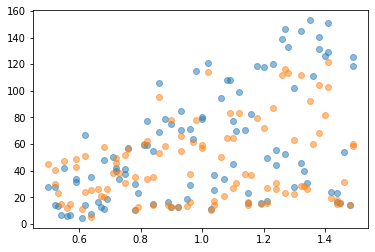

In [633]:
test_south = df_sims_south.groupby('cvar').mean()
test_north = df_sims_north.groupby('cvar').mean()
plt.scatter(test_south.rmax_ltir, test_south.dm_ear, alpha=0.5)
plt.scatter(test_north.rmax_ltir, test_north.dm_ear, alpha=0.5)

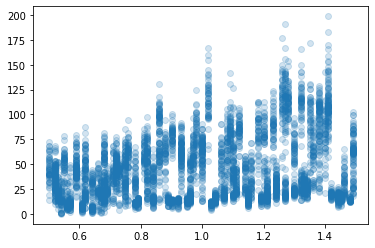

In [611]:
plt.scatter(df_sims_north.rmax_ltir, df_sims_north.dm_ear, alpha=0.2)

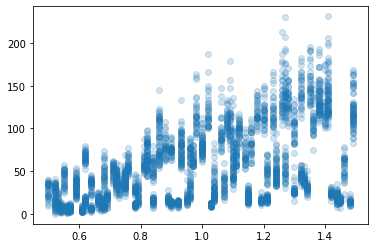

In [613]:
plt.scatter(df_sims_south.rmax_ltir, df_sims_south.dm_ear, alpha=0.2)

### Testing in terms of climate space

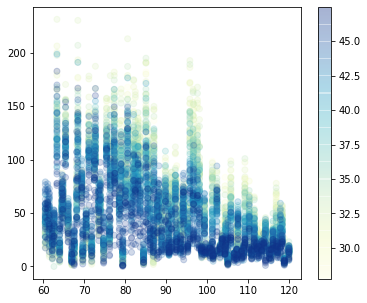

In [583]:
from palettable.colorbrewer.sequential import OrRd_6

fig = plt.figure(figsize=(6,5))
ax = plt.scatter(testt.Vpmax, testt.dm_ear, c=testt.lat, cmap=YlGnBu_8.mpl_colormap, alpha=0.2)
fig.colorbar(ax)

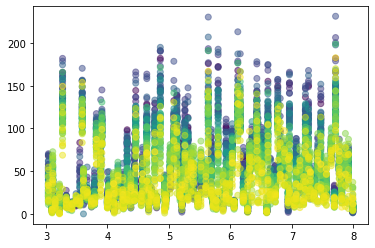

In [570]:
plt.scatter(testt.stayGreen, testt.dm_ear, c=testt.lat, alpha=0.5)

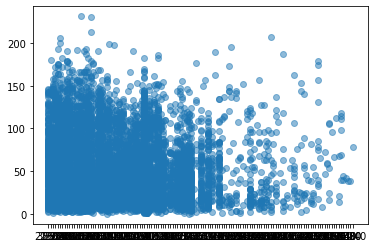

In [617]:
plt.scatter(df_sims.temp_air, df_sims.dm_ear, alpha=0.5)

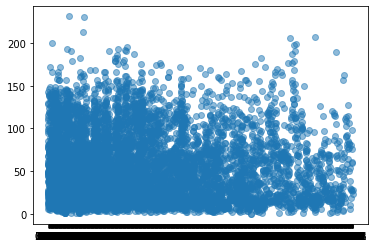

In [620]:
plt.scatter(df_sims.VPD, df_sims.dm_ear, alpha=0.5)

In [619]:
df_sims.columns

Index(['year', 'cvar', 'site', 'date', 'jday', 'time', 'leaves', 'mature_lvs',
       'drop_lvs', 'LA', 'LA_dead', 'LAI', 'RH', 'leaf_WP', 'PFD', 'solrad',
       'temp_soil', 'temp_air', 'temp_can', 'ET_dmd', 'ET_suply', 'Pn', 'Pg',
       'resp', 'av_gs', 'LAI_sunlit', 'LAI_shaded', 'PFD_sunlit', 'PFD_shaded',
       'An_sunlit', 'An_shaded', 'Ag_sunlit', 'Ag_shaded', 'gs_sunlit',
       'gs_shaded', 'VPD', 'N', 'N_dmd', 'N_upt', 'N_leaf', 'PCRL', 'dm_total',
       'dm_shoot', 'dm_ear', 'dm_totleaf', 'dm_dropleaf', 'df_stem', 'df_root',
       'roil_rt', 'mx_rootdept', 'available_water', 'soluble_c', 'note'],
      dtype='object')

In [673]:
sims_61 = df_sims[df_sims.year == '1961']

In [555]:
df_params['cvar'] = list(np.arange(0,100))

In [695]:
df_params = df_params.drop(['rmax_ltar'])

juv_leaves  stayGreen  rmax_ltir  phyllo  LM_min  Vcmax   Vpmax    g1  \
0           23       4.44       1.24    3.31   98.77  77.29   92.57  9.86   
1           16       7.13       0.55    3.98   89.85  67.10   87.81  1.37   
2           21       6.51       1.00    3.04   81.24  66.65   81.56  3.88   
3           24       4.67       0.68    3.24   97.70  69.56   69.67  4.86   
4           20       4.32       0.82    3.13  115.08  64.44  101.27  6.31   
..         ...        ...        ...     ...     ...    ...     ...   ...   
95          25       6.45       1.00    3.34   96.21  70.01   92.25  8.61   
96          22       6.28       0.57    3.87  103.52  79.57   84.49  1.70   
97          17       7.81       0.75    2.92  102.75  72.56  117.85  5.46   
98          17       6.03       0.93    3.19   84.43  61.38   80.06  5.22   
99          23       7.56       0.78    2.23   94.83  68.64   76.20  6.87   

    ref_potential  rmax_ltar  cvar  
0           -3.38       0.62     0  
1           -2.83       0.28     1  
2           -2.63       0.50     2  
3           -3.63       0.34     3  
4           -3.40       0.41     4  
..            ...        ...   ...  
95          -3.52       0.50    95  
96          -2.98       0.29    96  
97          -3.33       0.37    97  
98          -3.87       0.47    98  
99          -2.07       0.39    99  

[100 rows x 11 columns]

In [701]:
df_params_trans

0         1         2         3         4         5   \
juv_leaves  0.800000  0.100000  0.600000  0.900000  0.500000  0.400000   
stayGreen   0.288000  0.826000  0.702000  0.334000  0.264000  0.612000   
rmax_ltir   0.740000  0.050000  0.500000  0.180000  0.320000  0.400000   
phyllo      0.655000  0.990000  0.520000  0.620000  0.565000  0.010000   
LM_min      0.469250  0.246250  0.031000  0.442500  0.877000  0.000750   
Vcmax       0.864500  0.355000  0.332500  0.478000  0.222000  0.403500   
Vpmax       0.542833  0.463500  0.359333  0.161167  0.687833  0.806667   
g1          0.984444  0.041111  0.320000  0.428889  0.590000  0.086667   

                  6         7         8         9   ...        90        91  \
juv_leaves  0.500000  0.200000  0.000000  0.100000  ...  0.500000  0.600000   
stayGreen   0.372000  0.632000  0.904000  0.426000  ...  0.746000  0.686000   
rmax_ltir   0.850000  0.520000  0.600000  0.680000  ...  0.820000  0.910000   
phyllo      0.760000  0.370000  0.820000  0.395000  ...  0.875000  0.305000   
LM_min      0.910000  0.993000  0.323500  0.537000  ...  0.592000  0.125500   
Vcmax       0.093500  0.302500  0.324500  0.961000  ...  0.871000  0.631000   
Vpmax       0.417833  0.212500  0.587667  0.385833  ...  0.971500  0.186000   
g1          0.240000  0.665556  0.691111  0.564444  ...  0.885556  0.185556   

                  92        93        94        95        96        97  \
juv_leaves  0.200000  0.700000  0.400000  1.000000  0.700000  0.200000   
stayGreen   0.164000  0.416000  0.328000  0.690000  0.656000  0.962000   
rmax_ltir   0.620000  0.590000  0.480000  0.500000  0.070000  0.250000   
phyllo      0.385000  0.865000  0.335000  0.670000  0.935000  0.460000   
LM_min      0.349250  0.653250  0.732000  0.405250  0.588000  0.568750   
Vcmax       0.270500  0.845500  0.076000  0.500500  0.978500  0.628000   
Vpmax       0.291667  0.273167  0.374833  0.537500  0.408167  0.964167   
g1          0.096667  0.688889  0.901111  0.845556  0.077778  0.495556   

                  98        99  
juv_leaves  0.200000  0.800000  
stayGreen   0.606000  0.912000  
rmax_ltir   0.430000  0.280000  
phyllo      0.595000  0.115000  
LM_min      0.110750  0.370750  
Vcmax       0.069000  0.432000  
Vpmax       0.334333  0.270000  
g1          0.468889  0.652222  

[8 rows x 100 columns]

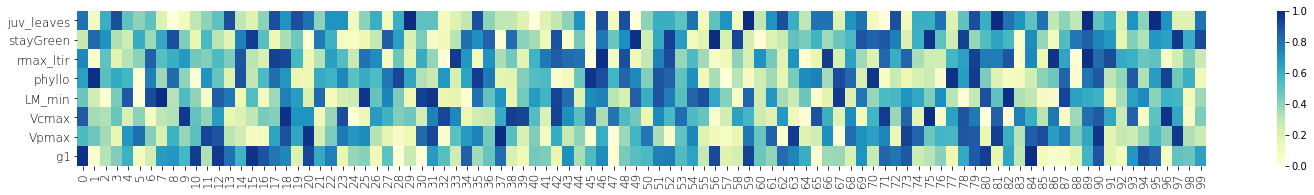

In [721]:
# setting parameter range

df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)

param_range = {'juv_leaves': [15, 25],
               'stayGreen': [3,8],
               'rmax_ltir': [0.5, 1.5],
               'phyllo': [2, 4],
               'LM_min': [80, 120],
               'Vcmax': [60, 80],
               'Vpmax': [60, 120],
               'g1': [1, 10], 
               'ref_potential': [-4, -1]}

params = df_params.columns[:-1]
df_params_fold = pd.DataFrame(columns=params)
for i in params: 
    df_params_fold[i] = fold(df_params[i], param_range[i][0], param_range[i][1])
df_params_trans = pd.DataFrame(df_params_fold.transpose())

fig, ax = plt.subplots(figsize=(28,5))
ax = sns.heatmap(df_params_trans, cmap=YlGnBu_8.mpl_colormap)

plt.xticks(fontweight='light', fontsize=12)
plt.yticks(rotation=0, fontweight='light', fontsize=12)

# adjusting color bar specifics
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
#fig.colorbar(ax, cax=cbar)

fig.subplots_adjust(left=0.2, bottom=0.45)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/params_100.png', format='png', dpi=800, transparent=True)

In [636]:
df_params.iloc[6]

juv_leaves        20.00
stayGreen          4.86
rmax_ltir          1.35
phyllo             3.52
LM_min           116.40
Vcmax             61.87
Vpmax             85.07
g1                 3.16
ref_potential     -2.44
rmax_ltar          0.68
cvar               6.00
Name: 6, dtype: float64

In [635]:
df_sims.groupby('site').mean()

cvar   dm_total   dm_ear
site                            
722060  49.5  208.42491  62.6107
722070  49.5  213.51583  57.9627
722080  49.5  218.65257  57.8049
722140  49.5  214.99107  53.8701
722170  49.5  203.91379  55.1786
...      ...        ...      ...
727640  49.5  196.73265  44.8705
727750  49.5  189.76097  48.0506
727810  49.5  216.47377  38.1293
727910  49.5  113.77440  22.9412
727920  49.5  155.32718  29.0032

[87 rows x 3 columns]

In [645]:
df_sims.groupby('cvar').mean().dm_ear

cvar
0.0     37.782989
1.0     45.171954
2.0     66.314828
3.0     16.691034
4.0     51.058046
          ...    
95.0    67.125747
96.0    11.855402
97.0    33.271034
98.0    73.563103
99.0    33.191609
Name: dm_ear, Length: 100, dtype: float64

In [654]:
test = pd.concat([df_params, pd.Series(df_sims.groupby('cvar').mean().dm_ear)], axis=1)
test.head()

juv_leaves  stayGreen  rmax_ltir  phyllo  LM_min  Vcmax   Vpmax    g1  \
0.0          23       4.44       1.24    3.31   98.77  77.29   92.57  9.86   
1.0          16       7.13       0.55    3.98   89.85  67.10   87.81  1.37   
2.0          21       6.51       1.00    3.04   81.24  66.65   81.56  3.88   
3.0          24       4.67       0.68    3.24   97.70  69.56   69.67  4.86   
4.0          20       4.32       0.82    3.13  115.08  64.44  101.27  6.31   

     ref_potential  rmax_ltar  cvar     dm_ear  
0.0          -3.38       0.62     0  37.782989  
1.0          -2.83       0.28     1  45.171954  
2.0          -2.63       0.50     2  66.314828  
3.0          -3.63       0.34     3  16.691034  
4.0          -3.40       0.41     4  51.058046

In [655]:
from partial_corr import partial_corr
output = partial_corr(test)

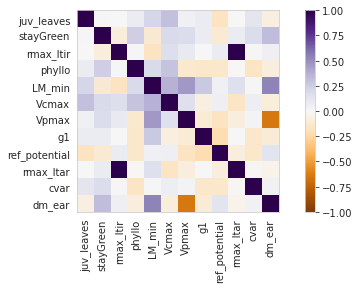

In [662]:
params = test.columns

with sns.axes_style('whitegrid'): # adding this line just makes the figure look a bit nicer
    
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(output, cmap='PuOr', vmin=-1, vmax=1)
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(params, rotation=90)
    ax.set_yticks(np.arange(0,12))
    ax.set_yticklabels(params, rotation=0)

    ax.grid(False)
    plt.colorbar(im)
    fig.subplots_adjust(left=-0.5, bottom=0.25, right=0.95, top=0.95)

    
    # 200429 - can further add * to indicate statistical significance
    #          when you have that info
    # 200429 - now that I'm thinking more, this figure is probably overkill
    #          since I don't really need all the correlatoins between all parameters
    #          maybe can modifiy this later to show correlation with different model output
    #          such as ear, total biomass, season length, etc. 

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/pcc.png', dpi=800)

#### *Note when converting from dm_ear to yield:
1. Planting density 
2. Shelling percentage (grain weight/ear weight)
    - scaler that converts ear mass to actual grain yield
    - 0.86 is the scale value used in previous paper but need to find citation to back it
    - Looking around seems like 0.8 is a common value people use when corn is harvested at ~20-25% grain moisture
    - Haven't really found a good citation yet, but here are a few links to start with: 
        - Tandzi and Mutengwa, 2020, Agronomy
        - Masuka et al., 2017, Crop Science (80% shelling percentage and 12.5% grain moisture)
        - Horrocks and Zuber, 1970